# Project **Finding Lane Lines on the Road**

## Import Packages

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions

In [6]:
import math

def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines):
    """    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    ### Helper Functions for draw_lines ###
    
    def get_average_line(lines):
        """
        input: set of lines defined by (x1, y1, x2, y2)
        output: a tuple (m, intercept) defining an average line
        """
        # Get the average slope for the given lines
        slopes = [(line[3]-line[1])/(line[2]-line[0]) for line in lines]
        m = np.average(slopes)
        
        # Get the average intercept for the given lines
        # using the bottom point as reference
        intercepts = [line[1]-((line[3]-line[1])/(line[2]-line[0]))*line[0] for line in lines]
        intercept = np.average(intercepts)
        
        return (m, intercept)
    
    def intersect(m1, b1, m2, b2):
        """
        input: set of slopes and intercepts
        output: (x, y) of intersect if it exists
        """
        x = (b2 - b1) / (m1 - m2)
        y = (b2 - (m2/m1) * b1)*(m1/(m1-m2))
        rslt = (x, y)

        return rslt
    
    def decide_draw_lines(img, left_coords, right_coords):
        """
        input: `img` to draw on, `left_coords` and `right_coords`
               to draw the respective lines in the form [x1, y1, x2, y2]
        """
        # Set image draw parameters
        color = [255, 0, 0]
        thickness = 10
        
        # Only draw lines if coords are actually passed
        if left_coords:
            cv2.line(img, tuple(left_coords[:2]), tuple(left_coords[2:]), color, thickness)
        if right_coords:
            cv2.line(img, tuple(right_coords[:2]), tuple(right_coords[2:]), color, thickness)
    
    def set_coords(m, b, y_lim):
        """
        input: given a line (`m` and `b`) generate the coords to 
               draw based on the image length (`y_lim`)
        output: a list of coords to define a lines with 
                integer positions in the form [x1, y1, x2, y2]
        """
        return list(map(int, [(y_lim-b)/m, y_lim, (0.5*y_lim-b)/m, 0.5*y_lim]))
    
    
    ### Begin Line Draw pipeline ###
    
    left_lines, right_lines = (None, None)
    
    # If lines are actually detected begin processing
    if lines.size != 0:
        lines = np.squeeze(lines)
        # Separate left and right lines into separate lists
        left_lines = [line for line in lines if (line[3]-line[1])/(line[2]-line[0]) < 0]
        right_lines = [line for line in lines if (line[3]-line[1])/(line[2]-line[0]) > 0]
    
    left_m, left_b = (None, None)
    right_m, right_b = (None, None)
    
    # If there exist lines in these sets, computer
    # the average line
    if left_lines:
        left_m, left_b = get_average_line(left_lines)
    if right_lines:
        right_m, right_b = get_average_line(right_lines)
    
    left_coords = None
    right_coords = None
    
    # Set coords based on left and right if line defneition exists
    y_lim = img.shape[0] # max y
    if left_m and left_b:
        left_coords = set_coords(left_m, left_b, y_lim)
    if right_m and right_b:
        right_coords = set_coords(right_m, right_b, y_lim)
    
    # Reset lines to match intersect point
    # if both left and right lines exist
    if left_coords and right_coords:
        remap_top_coord = intersect(left_m, left_b, right_m, right_b)
        remap_top_coord = list(map(int, remap_top_coord))
        left_coords = left_coords[:2] + remap_top_coord
        right_coords = right_coords[:2] + remap_top_coord
    
    # Finally, draw the lines on the passed in image
    decide_draw_lines(img, left_coords, right_coords)
    
def simple_draw_lines(img, lines, color = [255, 0, 0], thickness = 2):
    """
    input: `img` to drawn on, `lines` defined in [x1, y1, x2, y2] form
           `color` optionally in RGB form and `thickness` in pixels
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane Finding Pipeline

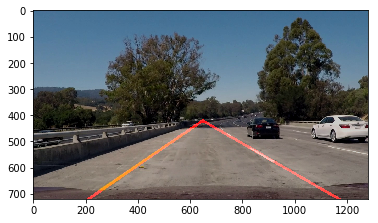

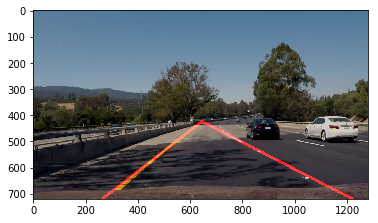

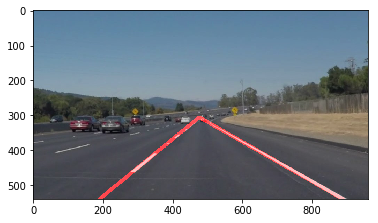

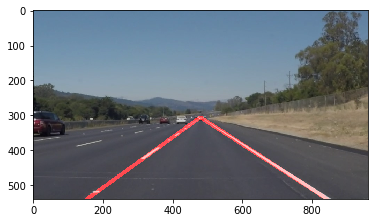

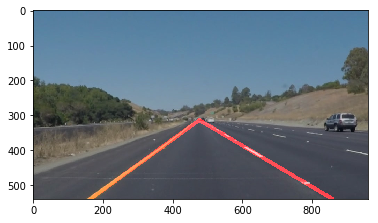

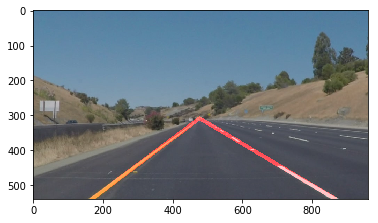

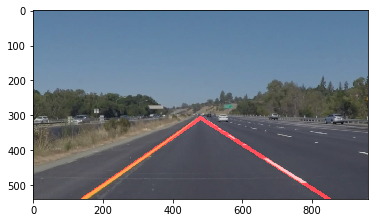

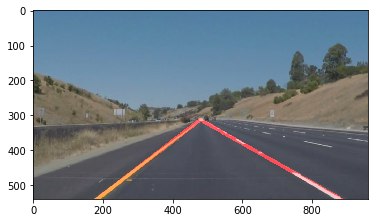

In [12]:
def find_lanes(img):
    """
    Input: `img` is an input matplotlib image
    Output: `rslt` is an annotated matplotlib image with the 
            lanes highlighted in red
    """
    
    # Create final return image copy
    rslt = img.copy()
    
    ### Color Detection Pipeline ###
    
    # Make image copies for display purposes
    color_select = np.copy(img)
    
    # Grab dimensions for masking
    y_dim = img.shape[0]
    x_dim = img.shape[1]
    
    # Apply a shape mask to color image to keep only lane sections
    verticies = np.array([[0.45*x_dim, 0.6*y_dim], [0.10*x_dim, y_dim], 
                          [0.25*x_dim, y_dim], [0.5*x_dim, 0.65*y_dim], 
                          [0.55*x_dim, 0.65*y_dim], [0.85*x_dim, y_dim], 
                          [0.95*x_dim, y_dim], [0.55*x_dim, 0.6*y_dim]], 
                         dtype=np.int32)
    color_select = region_of_interest(color_select, [verticies])
    
    # convert color space from RGB to HSV
    # for easier color selection
    color_select = cv2.cvtColor(color_select, cv2.COLOR_RGB2HSV)
    
    # Set mask HSV color range parameters
    h_lower, s_lower, v_lower = (0, 0, 220)
    h_upper, s_upper, v_upper = (180, 255, 255)
    mask = cv2.inRange(color_select,
                       np.array([h_lower, s_lower, v_lower]),
                       np.array([h_upper, s_upper, v_upper]))
    
    # Convert color select back to RGB
    color_select = cv2.cvtColor(color_select, cv2.COLOR_HSV2RGB)
    
    # Extend mask to three dimensions
    mask_3d = np.zeros_like(img)
    for i in range(3):
        mask_3d[:, :, i] = mask.copy()
    
    # Mask color select using 3d mask
    color_select = cv2.bitwise_and(color_select, mask_3d)
    
    ### Hough lines pipeline ###
    
    # Convert color selected image to grayscale
    gray = grayscale(color_select.copy())
    
    # Apply gaussian bluring
    blur = gaussian_blur(gray, 5)
    
    # Perform Canny edge detection
    canny_edges = canny(blur, 50, 150)
    
    # Create an image blank to drawn on
    line_image = np.copy(img)*0
    
    # Perform Hough lines detection
    hough_image = hough_lines(canny_edges, 1, np.pi/180, 20, 20, 5)
    
    # Draw the lines on the initial image
    rslt = weighted_img(hough_image, rslt, α=0.8, β=1., λ=0.)
    
    return rslt
    
# Main loop
path = 'test_images/'
for file in os.listdir(path):
    img = mpimg.imread(path+file)
    rslt = find_lanes(img)
    plt.figure()
    plt.imshow(rslt)

## Test on Videos

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    """
    Callback function for image processing
    """
    result = find_lanes(image)
    
    return result

## Solid White Right

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 62.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.89 s, sys: 1.5 s, total: 7.39 s
Wall time: 3.86 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Solid Yellow Left

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:10<00:00, 62.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 17.4 s, sys: 4.54 s, total: 21.9 s
Wall time: 11.2 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge

In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 36.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10 s, sys: 2.97 s, total: 13 s
Wall time: 8.06 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))